In [1]:
# import go here
import sys
import os
sys.path.append(os.path.abspath('..'))  # Add parent directory to path

from environment.knapsackgym import KnapsackEnv, _1_positive_reward, _1_negative_reward, v_i_positive_reward, vr_i_positive_reward, w_i_negative_reward, wr_i_negative_reward
from typing import List, Callable, Optional, Union, Tuple, Dict, Any
from models.DP_Knapsack import solve_knapsack_dp, solve_KP_instances_with_DP
from models.Greedy_Knapsack import solve_problem_instances_greedy
from models.KnapsackPPO import KnapsackPPOSolver
from models.KnapsackA2C import KnapsackA2C
from models.KnapsackQLearning import KnapsackDQN
from util.instance_gen import KnapsackInstanceGenerator
from util.metrics import evaluate_knapsack_performance
from models.KnapsackDRLSolver import KnapsackDRLSolver, run_KPSolver
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Tuple, Callable
import time
import itertools
import pandas as pd


# Plotting Code

In [2]:


def test_reward_functions_single_run(
    KPSolver_A2C: KnapsackA2C,
    KPSolver_DQN: KnapsackDQN,
    KPSolver_PPO: KnapsackPPOSolver,
    M: int = 10,
    instance_type: str = "RI",
    N: int = 50,
    r_range: int = 500,
    seed: int = 42,
    t_max: int = None,
    use_state_aggregation: bool = False,
    n_test_instances: int = 5,
    verbose: bool = True
) -> Dict[str, Any]:
    """
    Test different reward function combinations across multiple RL models for the Knapsack problem.
    
    Args:
        M (int): Number of problem instances to generate for training
        instance_type (str): Type of knapsack instances to generate ('RI', 'FI', 'HI', 'SS')
        N (int): Maximum number of items per problem instance
        r_range (int): Range parameter for instance generation
        seed (int): Random seed for reproducibility
        t_max (int): Maximum training steps (if None, will use default 3*N*10000)
        use_state_aggregation (bool): Whether to use state aggregation
        n_test_instances (int): Number of test instances to evaluate on
        verbose (bool): Whether to print detailed progress information
        
    Returns:
        Dict: Results and metrics for all experiments
    """
    # Set random seeds for reproducibility
    np.random.seed(seed)
    
    # Define the reward function combinations to test
    positive_reward_functions = {
        'v_i': v_i_positive_reward,
        'vr_i': vr_i_positive_reward,
        '_1': _1_positive_reward
    }
    
    negative_reward_functions = {
        'w_i': w_i_negative_reward,
        'wr_i': wr_i_negative_reward,
        '_1': _1_negative_reward
    }
    
    # Generate problem instances
    gen = KnapsackInstanceGenerator(seed=seed)
    
    if verbose:
        print(f"Generating {M} {instance_type} training instances with N={N}, R={r_range}")
    
    if instance_type == "RI":
        training_instances = gen.generate_random_instances(M, N, r_range, seed=seed)
        test_instances = gen.generate_random_instances(n_test_instances, N, r_range, seed=seed+100)
    elif instance_type == "FI":
        training_instances = gen.generate_fixed_instances(M, N, seed=seed)
        test_instances = gen.generate_fixed_instances(n_test_instances, N, seed=seed+100)
    elif instance_type == "HI":
        training_instances = gen.generate_hard_instances(M, N, r_range, seed=seed)
        test_instances = gen.generate_hard_instances(n_test_instances, N, r_range, seed=seed+100)
    elif instance_type == "SS":
        training_instances = gen.generate_subset_sum_instances(M, N, r_range, seed=seed)
        test_instances = gen.generate_subset_sum_instances(n_test_instances, N, r_range, seed=seed+100)
    else:
        raise ValueError(f"Unknown instance type: {instance_type}")
    
    # Solve instances with DP and Greedy for baselines
    if verbose: print("Computing DP optimal solutions for training instances...")
    dp_sols_items_train, dp_values_train, dp_weight_train = solve_KP_instances_with_DP(training_instances)

    if verbose: print("Computing Greedy solutions for training instances...")
    greedy_values_train, greedy_sols_items_train, greedy_weights_train = solve_problem_instances_greedy(training_instances)
    
    if verbose: print("Computing DP optimal solutions for test instances...")
    dp_sols_items_test, dp_values_test, dp_weight_test = solve_KP_instances_with_DP(test_instances)
    
    if verbose:
        print("Computing Greedy solutions for test instances...")
    greedy_values_test, greedy_sols_items_test, greedy_weights_test = solve_problem_instances_greedy(test_instances)
    
    # Define models to test
    model_constructors = {}
    if KPSolver_A2C is not None: model_constructors["A2C"] = KPSolver_A2C
    if KPSolver_DQN is not None: model_constructors["DQN"] = KPSolver_DQN
    if KPSolver_PPO is not None: model_constructors["PPO"] = KPSolver_PPO
    
    # Initialize results dictionary
    results = {
        'training': {},
        'test': {},
        'metrics': {},
        'config': {
            'num_instances': M,
            'instance_type': instance_type,
            'n_items': N,
            'r_range': r_range,
            'seed': seed,
            't_max': t_max,
            'use_state_aggregation': use_state_aggregation
        }
    }
    
    # Create all combinations of reward functions and models
    reward_combinations = list(itertools.product(
        positive_reward_functions.items(),
        negative_reward_functions.items()
    ))
    
    # Total count of experiments
    total_experiments = len(reward_combinations) * len(model_constructors)
    
    if verbose:
        print(f"Running {total_experiments} experiments...")
    
    experiment_counter = 0
    
    # Run experiments for each model and reward function combination
    for model_name, model in model_constructors.items():
        results['training'][model_name] = {}
        results['test'][model_name] = {}
        results['metrics'][model_name] = {}
        
        for (pos_name, pos_func), (neg_name, neg_func) in reward_combinations:
            experiment_counter += 1
            reward_combo_name = f"(+{pos_name} -{neg_name})"
            
            if verbose:
                print(f"\nExperiment {experiment_counter}/{total_experiments}: Testing {model_name} with {reward_combo_name}")
                print(f"Positive reward: {pos_name}, Negative reward: {neg_name}")
            
            # Create environment with specific reward functions
            env = KnapsackEnv(
                problem_instance=None,
                N=N,
                positive_reward_function=pos_func,
                negative_reward_function=neg_func
            )
            
            # Initialize the model
            kp_solver = model
            
            # Train the model
            start_time = time.time()
            
            solver, solution_values = run_KPSolver(
                env=env,
                KPSolver=kp_solver,
                training_problem_instances=training_instances,
                t_max=t_max,
                use_state_aggregation=use_state_aggregation,
                verbose=verbose
            )
            
            training_time = time.time() - start_time
            
            # Store training results
            results['training'][model_name][reward_combo_name] = {
                'solution_values': solution_values,
                'training_time': training_time
            }
            
            # Evaluate on test instances
            test_values = []
            for instance in test_instances:
                env.change_problem_instance(instance)
                # value, weight, _ = kp_solver.solve(instance)
                value, weight, _ = solver.solve(instance)
                test_values.append(value)
            
            # Calculate performance metrics
            
            # For training instances
            train_best_values = solution_values['instance_best_values']
            train_metrics = evaluate_knapsack_performance(
                train_best_values, 
                dp_values_train, 
                greedy_values_train
            )
            
            # For test instances
            test_metrics = evaluate_knapsack_performance(
                test_values,
                dp_values_test,
                greedy_values_test
            )
            
            # Store test results and metrics
            results['test'][model_name][reward_combo_name] = {
                'values': test_values,
                'metrics': test_metrics
            }
            
            results['metrics'][model_name][reward_combo_name] = {
                'train': train_metrics,
                'test': test_metrics
            }
            
            if verbose:
                print(f"Training metrics for {model_name} with {reward_combo_name}:")
                print(f"  Val/Opt Ratio: {train_metrics['ValOptRatio']:.2f}%")
                print(f"  #opt: {train_metrics['#opt']}/{M}")
                print(f"  Mean percentage error: {train_metrics['mean_percentage_error']:.4f}")
                print(f"  Mean improvement over greedy: {train_metrics['mean_improvement_over_greedy']:.4f}")
                
                print(f"Test metrics for {model_name} with {reward_combo_name}:")
                print(f"  Val/Opt Ratio: {test_metrics['ValOptRatio']:.2f}%")
                print(f"  #opt: {test_metrics['#opt']}/{n_test_instances}")
                print(f"  Mean percentage error: {test_metrics['mean_percentage_error']:.4f}")
                print(f"  Mean improvement over greedy: {test_metrics['mean_improvement_over_greedy']:.4f}")
    
    # Generate summary table
    summary = create_summary_table(results)
    results['summary'] = summary
    
    # Generate visualizations
    visualize_results(results)
    
    return results

def create_summary_table(results: Dict[str, Any]) -> pd.DataFrame:
    """
    Create a summary table of all experiments.
    
    Args:
        results: Results dictionary from test_reward_functions
        
    Returns:
        pd.DataFrame: Summary table
    """
    rows = []
    
    for model_name in results['metrics']:
        for reward_combo_name, metrics in results['metrics'][model_name].items():
            train_metrics = metrics['train']
            test_metrics = metrics['test']
            
            row = {
                'Model': model_name,
                'Reward': reward_combo_name,
                'Train_ValOptRatio': train_metrics['ValOptRatio'],
                'Train_#opt': train_metrics['#opt'],
                'Train_MAE': train_metrics['mean_absolute_error'],
                'Train_MPE': train_metrics['mean_percentage_error'],
                'Train_vs_Greedy': train_metrics['mean_improvement_over_greedy'],
                'Test_ValOptRatio': test_metrics['ValOptRatio'],
                'Test_#opt': test_metrics['#opt'],
                'Test_MAE': test_metrics['mean_absolute_error'],
                'Test_MPE': test_metrics['mean_percentage_error'],
                'Test_vs_Greedy': test_metrics['mean_improvement_over_greedy']
            }
            
            rows.append(row)
    
    df = pd.DataFrame(rows)
    return df

def visualize_results(results: Dict[str, Any]) -> None:
    """
    Generate visualizations for the experiment results.
    
    Args:
        results: Results dictionary from test_reward_functions
    """
    # Compare Val/Opt Ratio across models and reward functions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    summary_df = results['summary']
    
    # Create data for grouped bar chart
    models = summary_df['Model'].unique()
    rewards = summary_df['Reward'].unique()
    
    width = 0.8 / len(rewards)
    x = np.arange(len(models))
    
    # Training ValOptRatio chart
    for i, reward in enumerate(rewards):
        values = [summary_df[(summary_df['Model'] == model) & (summary_df['Reward'] == reward)]['Train_ValOptRatio'].values[0] 
                 for model in models]
        ax1.bar(x + i*width - 0.4 + width/2, values, width, label=reward)
    
    ax1.set_ylabel('Val/Opt Ratio (%)')
    ax1.set_title('Training Val/Opt Ratio by Model and Reward')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.legend(title='Reward')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Test ValOptRatio chart
    for i, reward in enumerate(rewards):
        values = [summary_df[(summary_df['Model'] == model) & (summary_df['Reward'] == reward)]['Test_ValOptRatio'].values[0] 
                 for model in models]
        ax2.bar(x + i*width - 0.4 + width/2, values, width, label=reward)
    
    ax2.set_ylabel('Val/Opt Ratio (%)')
    ax2.set_title('Test Val/Opt Ratio by Model and Reward')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models)
    ax2.legend(title='Reward')
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('val_opt_ratio_comparison.png')
    
    # Create heatmap for reward function performance
    plt.figure(figsize=(12, 8))
    
    # Reshape data for heatmap
    pos_rewards = list(set([r.split('_')[0] for r in rewards]))
    neg_rewards = list(set([r.split('_')[1] for r in rewards]))
    
    heatmap_data = np.zeros((len(models), len(pos_rewards), len(neg_rewards)))
    
    for i, model in enumerate(models):
        for j, pos in enumerate(pos_rewards):
            for k, neg in enumerate(neg_rewards):
                reward = f"{pos}_{neg}"
                try:
                    val = summary_df[(summary_df['Model'] == model) & (summary_df['Reward'] == reward)]['Test_ValOptRatio'].values[0]
                    heatmap_data[i, j, k] = val
                except:
                    heatmap_data[i, j, k] = 0
    
    # Create subplots for each model
    fig, axes = plt.subplots(1, len(models), figsize=(16, 6))
    if len(models) == 1:
        axes = [axes]
    
    for i, model in enumerate(models):
        im = axes[i].imshow(heatmap_data[i], cmap='viridis')
        axes[i].set_title(f'{model}')
        axes[i].set_xticks(np.arange(len(neg_rewards)))
        axes[i].set_yticks(np.arange(len(pos_rewards)))
        axes[i].set_xticklabels(neg_rewards)
        axes[i].set_yticklabels(pos_rewards)
        axes[i].set_xlabel('Negative Reward')
        if i == 0:
            axes[i].set_ylabel('Positive Reward')
            
        # Loop over data dimensions and create text annotations
        for j in range(len(pos_rewards)):
            for k in range(len(neg_rewards)):
                text = axes[i].text(k, j, f"{heatmap_data[i, j, k]:.1f}",
                            ha="center", va="center", color="w" if heatmap_data[i, j, k] < 70 else "black")
    
    fig.colorbar(im, ax=axes, shrink=0.8, label='Val/Opt Ratio (%)')
    plt.tight_layout()
    plt.savefig('reward_function_heatmap.png')
    
    # Plot convergence over time
    for model_name in results['training']:
        plt.figure(figsize=(10, 6))
        
        for reward_combo_name in results['training'][model_name]:
            solution_values = results['training'][model_name][reward_combo_name]['solution_values']
            best_sum_over_time = solution_values['best_sum_over_time']
            t_values = np.arange(len(best_sum_over_time))
            
            plt.plot(t_values, best_sum_over_time, label=reward_combo_name)
        
        plt.xlabel('Training Iterations')
        plt.ylabel('Sum of Best Values')
        plt.title(f'Convergence for {model_name}')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f'convergence_{model_name}.png')

In [3]:
def test_reward_functions(
    KPSolver_A2C: KnapsackA2C,
    KPSolver_DQN: KnapsackDQN,
    KPSolver_PPO: KnapsackPPOSolver,
    M: int = 10,
    instance_type: str = "RI",
    N: int = 50,
    r_range: int = 500,
    seed: int = 42,
    t_max: int = None,
    use_state_aggregation: bool = False,
    n_test_instances: int = 5,
    verbose: bool = True,
    n_runs: int = 10  # Number of runs to average results over
) -> Dict[str, Any]:
    """
    Test different reward function combinations across multiple RL models for the Knapsack problem.
    Runs each experiment n_runs times and averages the results.
    
    Args:
        M (int): Number of problem instances to generate for training
        instance_type (str): Type of knapsack instances to generate ('RI', 'FI', 'HI', 'SS')
        N (int): Maximum number of items per problem instance
        r_range (int): Range parameter for instance generation
        seed (int): Base random seed for reproducibility
        t_max (int): Maximum training steps (if None, will use default 3*N*10000)
        use_state_aggregation (bool): Whether to use state aggregation
        n_test_instances (int): Number of test instances to evaluate on
        verbose (bool): Whether to print detailed progress information
        n_runs (int): Number of runs to average results over
        
    Returns:
        Dict: Results and metrics for all experiments, including averaged metrics
    """
    # Define the reward function combinations to test
    positive_reward_functions = {
        'v_i': v_i_positive_reward,
        'vr_i': vr_i_positive_reward,
        '_1': _1_positive_reward
    }
    
    negative_reward_functions = {
        'w_i': w_i_negative_reward,
        'wr_i': wr_i_negative_reward,
        '_1': _1_negative_reward
    }
    
    # Create all combinations of reward functions and models
    # reward_combinations = list(itertools.product(
    #     positive_reward_functions.items(),
    #     negative_reward_functions.items()
    # ))
    reward_combinations = [
        (('vr_i', positive_reward_functions['vr_i']), ('wr_i', negative_reward_functions['wr_i'])),
        (('vr_i', positive_reward_functions['vr_i']), ('w_i', negative_reward_functions['w_i'])),
        (('v_i', positive_reward_functions['v_i']), ('wr_i', negative_reward_functions['wr_i'])),
        (('v_i', positive_reward_functions['v_i']), ('w_i', negative_reward_functions['w_i'])),
        (('_1', positive_reward_functions['_1']), ('_1', negative_reward_functions['_1']))
    ]

    
    # Define models to test
    model_constructors = {}
    if KPSolver_A2C is not None: model_constructors["A2C"] = KPSolver_A2C
    if KPSolver_DQN is not None: model_constructors["DQN"] = KPSolver_DQN
    if KPSolver_PPO is not None: model_constructors["PPO"] = KPSolver_PPO
    
    # Initialize results dictionary
    results = {
        'training': {},
        'test': {},
        'metrics': {},
        'config': {
            'num_instances': M,
            'instance_type': instance_type,
            'n_items': N,
            'r_range': r_range,
            'base_seed': seed,
            't_max': t_max,
            'use_state_aggregation': use_state_aggregation,
            'n_runs': n_runs
        }
    }
    
    # Total count of experiments
    total_experiments = len(reward_combinations) * len(model_constructors)
    
    if verbose:
        print(f"Running {total_experiments} experiments, each with {n_runs} runs...")
    
    experiment_counter = 0
    
    # Run experiments for each model and reward function combination
    for model_name, model in model_constructors.items():
        results['training'][model_name] = {}
        results['test'][model_name] = {}
        results['metrics'][model_name] = {}
        
        for (pos_name, pos_func), (neg_name, neg_func) in reward_combinations:
            experiment_counter += 1
            reward_combo_name = f"(+{pos_name} -{neg_name})"
            
            if verbose:
                print(f"\nExperiment {experiment_counter}/{total_experiments}: Testing {model_name} with {reward_combo_name}")
                print(f"Positive reward: {pos_name}, Negative reward: {neg_name}")
                print(f"Running {n_runs} times and averaging results...")
            
            # Initialize storage for multiple runs
            all_training_values = []
            all_test_values = []
            all_training_times = []
            all_train_metrics = []
            all_test_metrics = []
            
            # Run the experiment n_runs times
            for run in range(n_runs):
                # Set different seed for each run
                run_seed = seed + run * 1000
                np.random.seed(run_seed)
                
                if verbose:
                    print(f"\nRun {run+1}/{n_runs} (seed={run_seed}):")
                
                # Generate problem instances for this run
                gen = KnapsackInstanceGenerator(seed=run_seed)
                
                if instance_type == "RI":
                    training_instances = gen.generate_random_instances(M, N, r_range, seed=run_seed)
                    test_instances = gen.generate_random_instances(n_test_instances, N, r_range, seed=run_seed+100)
                elif instance_type == "FI":
                    training_instances = gen.generate_fixed_instances(M, N, seed=run_seed)
                    test_instances = gen.generate_fixed_instances(n_test_instances, N, seed=run_seed+100)
                elif instance_type == "HI":
                    training_instances = gen.generate_hard_instances(M, N, r_range, seed=run_seed)
                    test_instances = gen.generate_hard_instances(n_test_instances, N, r_range, seed=run_seed+100)
                elif instance_type == "SS":
                    training_instances = gen.generate_subset_sum_instances(M, N, r_range, seed=run_seed)
                    test_instances = gen.generate_subset_sum_instances(n_test_instances, N, r_range, seed=run_seed+100)
                else:
                    raise ValueError(f"Unknown instance type: {instance_type}")
                
                # Solve instances with DP and Greedy for baselines
                if verbose: print("Computing DP optimal solutions for training instances...")
                dp_sols_items_train, dp_values_train, dp_weight_train = solve_KP_instances_with_DP(training_instances)

                if verbose: print("Computing Greedy solutions for training instances...")
                greedy_values_train, greedy_sols_items_train, greedy_weights_train = solve_problem_instances_greedy(training_instances)
                
                if verbose: print("Computing DP optimal solutions for test instances...")
                dp_sols_items_test, dp_values_test, dp_weight_test = solve_KP_instances_with_DP(test_instances)
                
                if verbose: print("Computing Greedy solutions for test instances...")
                greedy_values_test, greedy_sols_items_test, greedy_weights_test = solve_problem_instances_greedy(test_instances)
                
                # Create environment with specific reward functions
                env = KnapsackEnv(
                    problem_instance=None,
                    N=N,
                    positive_reward_function=pos_func,
                    negative_reward_function=neg_func
                )
                
                # Initialize the model
                kp_solver = model
                
                # Train the model
                start_time = time.time()
                
                solver, solution_values = run_KPSolver(
                    env=env,
                    KPSolver=kp_solver,
                    training_problem_instances=training_instances,
                    t_max=t_max,
                    use_state_aggregation=use_state_aggregation,
                    verbose=verbose
                )
                
                training_time = time.time() - start_time
                all_training_times.append(training_time)
                
                # Store training results for this run
                all_training_values.append(solution_values)
                
                # Evaluate on test instances
                test_values = []
                for instance in test_instances:
                    env.change_problem_instance(instance)
                    value, weight, _ = solver.solve(instance)
                    test_values.append(value)
                
                all_test_values.append(test_values)
                
                # Calculate performance metrics for this run
                # For training instances
                train_best_values = solution_values['instance_best_values']
                train_metrics = evaluate_knapsack_performance(
                    train_best_values, 
                    dp_values_train, 
                    greedy_values_train
                )
                all_train_metrics.append(train_metrics)
                
                # For test instances
                test_metrics = evaluate_knapsack_performance(
                    test_values,
                    dp_values_test,
                    greedy_values_test
                )
                all_test_metrics.append(test_metrics)
                
                if verbose:
                    print(f"Run {run+1} training metrics for {model_name} with {reward_combo_name}:")
                    print(f"  Val/Opt Ratio: {train_metrics['ValOptRatio']:.2f}%")
                    print(f"  #opt: {train_metrics['#opt']}/{M}")
                    print(f"  Mean percentage error: {train_metrics['mean_percentage_error']:.4f}")
                    print(f"  Mean improvement over greedy: {train_metrics['mean_improvement_over_greedy']:.4f}")
                    
                    print(f"Run {run+1} test metrics for {model_name} with {reward_combo_name}:")
                    print(f"  Val/Opt Ratio: {test_metrics['ValOptRatio']:.2f}%")
                    print(f"  #opt: {test_metrics['#opt']}/{n_test_instances}")
                    print(f"  Mean percentage error: {test_metrics['mean_percentage_error']:.4f}")
                    print(f"  Mean improvement over greedy: {test_metrics['mean_improvement_over_greedy']:.4f}")
            
            # Calculate averages across all runs
            avg_training_time = np.mean(all_training_times)
            
            # Average training metrics
            avg_train_metrics = {
                'ValOptRatio': np.mean([m['ValOptRatio'] for m in all_train_metrics]),
                '#opt': np.mean([m['#opt'] for m in all_train_metrics]),
                'mean_percentage_error': np.mean([m['mean_percentage_error'] for m in all_train_metrics]),
                'mean_improvement_over_greedy': np.mean([m['mean_improvement_over_greedy'] for m in all_train_metrics])
            }
            
            # Calculate std dev of metrics for error bars
            std_train_metrics = {
                'ValOptRatio': np.std([m['ValOptRatio'] for m in all_train_metrics]),
                '#opt': np.std([m['#opt'] for m in all_train_metrics]),
                'mean_percentage_error': np.std([m['mean_percentage_error'] for m in all_train_metrics]),
                'mean_improvement_over_greedy': np.std([m['mean_improvement_over_greedy'] for m in all_train_metrics])
            }
            
            # Average test metrics
            avg_test_metrics = {
                'ValOptRatio': np.mean([m['ValOptRatio'] for m in all_test_metrics]),
                '#opt': np.mean([m['#opt'] for m in all_test_metrics]),
                'mean_percentage_error': np.mean([m['mean_percentage_error'] for m in all_test_metrics]),
                'mean_improvement_over_greedy': np.mean([m['mean_improvement_over_greedy'] for m in all_test_metrics])
            }
            
            # Calculate std dev of test metrics for error bars
            std_test_metrics = {
                'ValOptRatio': np.std([m['ValOptRatio'] for m in all_test_metrics]),
                '#opt': np.std([m['#opt'] for m in all_test_metrics]),
                'mean_percentage_error': np.std([m['mean_percentage_error'] for m in all_test_metrics]),
                'mean_improvement_over_greedy': np.std([m['mean_improvement_over_greedy'] for m in all_test_metrics])
            }
            
            # Store averaged results
            results['training'][model_name][reward_combo_name] = {
                'solution_values': all_training_values,  # Store all runs
                'avg_training_time': avg_training_time,
                'avg_metrics': avg_train_metrics,
                'std_metrics': std_train_metrics
            }
            
            results['test'][model_name][reward_combo_name] = {
                'values': all_test_values,  # Store all runs
                'avg_metrics': avg_test_metrics,
                'std_metrics': std_test_metrics
            }
            
            results['metrics'][model_name][reward_combo_name] = {
                'train': {
                    'avg': avg_train_metrics,
                    'std': std_train_metrics,
                    'all_runs': all_train_metrics
                },
                'test': {
                    'avg': avg_test_metrics,
                    'std': std_test_metrics,
                    'all_runs': all_test_metrics
                }
            }
            
            if verbose:
                print(f"\nAVERAGED RESULTS ({n_runs} runs) for {model_name} with {reward_combo_name}:")
                print(f"Training metrics:")
                print(f"  Val/Opt Ratio: {avg_train_metrics['ValOptRatio']:.2f}% ± {std_train_metrics['ValOptRatio']:.2f}%")
                print(f"  #opt: {avg_train_metrics['#opt']:.2f} ± {std_train_metrics['#opt']:.2f}")
                print(f"  Mean percentage error: {avg_train_metrics['mean_percentage_error']:.4f} ± {std_train_metrics['mean_percentage_error']:.4f}")
                print(f"  Mean improvement over greedy: {avg_train_metrics['mean_improvement_over_greedy']:.4f} ± {std_train_metrics['mean_improvement_over_greedy']:.4f}")
                
                print(f"Test metrics:")
                print(f"  Val/Opt Ratio: {avg_test_metrics['ValOptRatio']:.2f}% ± {std_test_metrics['ValOptRatio']:.2f}%")
                print(f"  #opt: {avg_test_metrics['#opt']:.2f} ± {std_test_metrics['#opt']:.2f}")
                print(f"  Mean percentage error: {avg_test_metrics['mean_percentage_error']:.4f} ± {std_test_metrics['mean_percentage_error']:.4f}")
                print(f"  Mean improvement over greedy: {avg_test_metrics['mean_improvement_over_greedy']:.4f} ± {std_test_metrics['mean_improvement_over_greedy']:.4f}")
    
    # Generate summary table with averaged results
    summary = create_summary_table_with_std(results, n_runs)
    results['summary'] = summary
    
    # Generate visualizations with error bars
    visualize_results_with_error_bars(results)
    
    return results


def create_summary_table_with_std(results, n_runs):
    """
    Create a summary table of the experiment results across all models and reward functions,
    including standard deviations.
    
    Args:
        results: Dictionary containing experiment results
        n_runs: Number of runs performed for each experiment
        
    Returns:
        DataFrame: Summary table with metrics and standard deviations
    """
    rows = []
    
    for model_name in results['metrics']:
        for reward_combo in results['metrics'][model_name]:
            # Training metrics
            train_metrics = results['metrics'][model_name][reward_combo]['train']['avg']
            train_std = results['metrics'][model_name][reward_combo]['train']['std']
            
            # Test metrics
            test_metrics = results['metrics'][model_name][reward_combo]['test']['avg']
            test_std = results['metrics'][model_name][reward_combo]['test']['std']
            
            # Average training time
            avg_training_time = results['training'][model_name][reward_combo]['avg_training_time']
            
            row = {
                'Model': model_name,
                'Reward Function': reward_combo,
                'Train Val/Opt (%)': f"{train_metrics['ValOptRatio']:.2f} ± {train_std['ValOptRatio']:.2f}",
                'Train #opt': f"{train_metrics['#opt']:.2f} ± {train_std['#opt']:.2f}",
                'Train MPE': f"{train_metrics['mean_percentage_error']:.4f} ± {train_std['mean_percentage_error']:.4f}",
                'Train Imp/Greedy': f"{train_metrics['mean_improvement_over_greedy']:.4f} ± {train_std['mean_improvement_over_greedy']:.4f}",
                'Test Val/Opt (%)': f"{test_metrics['ValOptRatio']:.2f} ± {test_std['ValOptRatio']:.2f}",
                'Test #opt': f"{test_metrics['#opt']:.2f} ± {test_std['#opt']:.2f}",
                'Test MPE': f"{test_metrics['mean_percentage_error']:.4f} ± {test_std['mean_percentage_error']:.4f}",
                'Test Imp/Greedy': f"{test_metrics['mean_improvement_over_greedy']:.4f} ± {test_std['mean_improvement_over_greedy']:.4f}",
                'Training Time (s)': f"{avg_training_time:.2f}"
            }
            rows.append(row)
    
    # Create DataFrame
    summary_df = pd.DataFrame(rows)
    
    # Add note about number of runs
    summary_df.attrs['note'] = f"Results averaged over {n_runs} runs. ± values indicate standard deviation."
    
    return summary_df


def visualize_results_with_error_bars(results, save_fig:bool=False):
    """
    Generate visualizations of the experiment results with error bars.
    
    Args:
        results: Dictionary containing experiment results
    """
    # Create matplotlib figure
    plt.figure(figsize=(14, 10))
    
    # Prepare data for plotting
    models = list(results['metrics'].keys())
    reward_combos = []
    for model in models:
        reward_combos.extend(list(results['metrics'][model].keys()))
    reward_combos = list(set(reward_combos))  # Remove duplicates
    
    # Prepare data for Val/Opt Ratio (test set)
    x = np.arange(len(reward_combos))
    width = 0.8 / len(models)  # Width of bars
    
    # Plot Val/Opt Ratio for test set with error bars
    plt.subplot(2, 2, 1)
    for i, model in enumerate(models):
        values = []
        errors = []
        for reward in reward_combos:
            if reward in results['metrics'][model]:
                values.append(results['metrics'][model][reward]['test']['avg']['ValOptRatio'])
                errors.append(results['metrics'][model][reward]['test']['std']['ValOptRatio'])
            else:
                values.append(0)
                errors.append(0)
        
        plt.bar(x + i*width - width*(len(models)-1)/2, values, width, label=model, yerr=errors, capsize=3)
    
    plt.ylabel('Val/Opt Ratio (%)')
    plt.title('Test Set Val/Opt Ratio by Model and Reward Function')
    plt.xticks(x, reward_combos, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Plot #opt for test set with error bars
    plt.subplot(2, 2, 2)
    for i, model in enumerate(models):
        values = []
        errors = []
        for reward in reward_combos:
            if reward in results['metrics'][model]:
                values.append(results['metrics'][model][reward]['test']['avg']['#opt'])
                errors.append(results['metrics'][model][reward]['test']['std']['#opt'])
            else:
                values.append(0)
                errors.append(0)
        
        plt.bar(x + i*width - width*(len(models)-1)/2, values, width, label=model, yerr=errors, capsize=3)
    
    plt.ylabel('Number of Optimal Solutions')
    plt.title('Test Set #opt by Model and Reward Function')
    plt.xticks(x, reward_combos, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Plot Mean Percentage Error for test set with error bars
    plt.subplot(2, 2, 3)
    for i, model in enumerate(models):
        values = []
        errors = []
        for reward in reward_combos:
            if reward in results['metrics'][model]:
                values.append(results['metrics'][model][reward]['test']['avg']['mean_percentage_error'])
                errors.append(results['metrics'][model][reward]['test']['std']['mean_percentage_error'])
            else:
                values.append(0)
                errors.append(0)
        
        plt.bar(x + i*width - width*(len(models)-1)/2, values, width, label=model, yerr=errors, capsize=3)
    
    plt.ylabel('Mean Percentage Error')
    plt.title('Test Set Mean Percentage Error by Model and Reward Function')
    plt.xticks(x, reward_combos, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Plot Mean Improvement over Greedy for test set with error bars
    plt.subplot(2, 2, 4)
    for i, model in enumerate(models):
        values = []
        errors = []
        for reward in reward_combos:
            if reward in results['metrics'][model]:
                values.append(results['metrics'][model][reward]['test']['avg']['mean_improvement_over_greedy'])
                errors.append(results['metrics'][model][reward]['test']['std']['mean_improvement_over_greedy'])
            else:
                values.append(0)
                errors.append(0)
        
        plt.bar(x + i*width - width*(len(models)-1)/2, values, width, label=model, yerr=errors, capsize=3)
    
    plt.ylabel('Mean Improvement over Greedy')
    plt.title('Test Set Mean Improvement over Greedy by Model and Reward Function')
    plt.xticks(x, reward_combos, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    if save_fig: plt.savefig('experiment_results_with_error_bars.png', dpi=300)
    plt.close()
    
    # Create additional visualizations for training performance
    plt.figure(figsize=(14, 10))
    
    # Plot Val/Opt Ratio for training set with error bars
    plt.subplot(2, 2, 1)
    for i, model in enumerate(models):
        values = []
        errors = []
        for reward in reward_combos:
            if reward in results['metrics'][model]:
                values.append(results['metrics'][model][reward]['train']['avg']['ValOptRatio'])
                errors.append(results['metrics'][model][reward]['train']['std']['ValOptRatio'])
            else:
                values.append(0)
                errors.append(0)
        
        plt.bar(x + i*width - width*(len(models)-1)/2, values, width, label=model, yerr=errors, capsize=3)
    
    plt.ylabel('Val/Opt Ratio (%)')
    plt.title('Training Set Val/Opt Ratio by Model and Reward Function')
    plt.xticks(x, reward_combos, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Plot Training Times
    plt.subplot(2, 2, 2)
    for i, model in enumerate(models):
        values = []
        for reward in reward_combos:
            if reward in results['training'][model]:
                values.append(results['training'][model][reward]['avg_training_time'])
            else:
                values.append(0)
        
        plt.bar(x + i*width - width*(len(models)-1)/2, values, width, label=model)
    
    plt.ylabel('Training Time (seconds)')
    plt.title('Average Training Time by Model and Reward Function')
    plt.xticks(x, reward_combos, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    if save_fig: plt.savefig('training_performance_with_error_bars.png', dpi=300)
    plt.show()
    plt.close()

# Plotting
This jupyter notebook will be used to generate relevant plots relating to our experiments


Running 15 experiments, each with 10 runs...

Experiment 1/15: Testing A2C with (+vr_i -wr_i)
Positive reward: vr_i, Negative reward: wr_i
Running 10 times and averaging results...

Run 1/10 (seed=42):
Computing DP optimal solutions for training instances...
Computing Greedy solutions for training instances...
Computing DP optimal solutions for test instances...
Computing Greedy solutions for test instances...
Running Model <class 'models.KnapsackA2C.KnapsackA2C'>
Training on 1000 KP Instances, with N=50, t_max=10000
Iteration [0/10000], Training KP Instance 0, Reward: -0.005276762817043792
Iteration [1000/10000], Training KP Instance 0, Reward: -0.0348938319928081
Iteration [2000/10000], Training KP Instance 0, Reward: -0.004517794822580917
Iteration [3000/10000], Training KP Instance 0, Reward: -0.012955943704415804
Iteration [4000/10000], Training KP Instance 0, Reward: -0.0348938319928081
Iteration [5000/10000], Training KP Instance 0, Reward: -0.04680122243024061
Iteration [6000/1

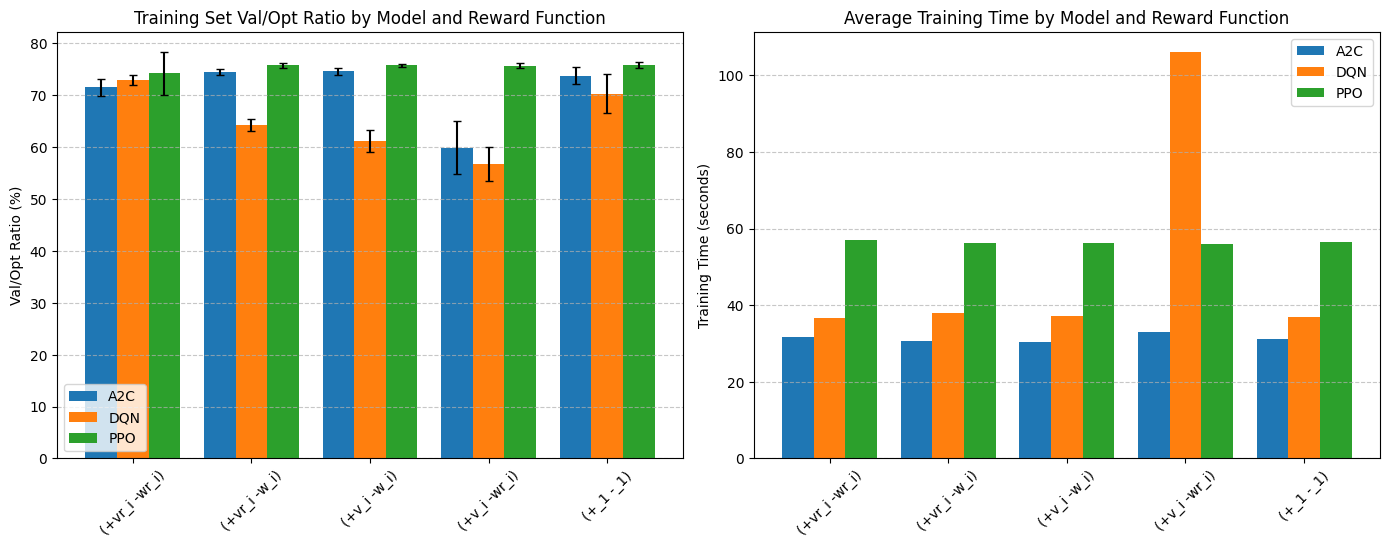


Summary of Results:
   Model Reward Function Train Val/Opt (%)      Train #opt        Train MPE  \
0    A2C   (+vr_i -wr_i)      71.50 ± 1.68  234.60 ± 13.86  0.2221 ± 0.0153   
1    A2C    (+vr_i -w_i)      74.49 ± 0.65  281.10 ± 12.75  0.1886 ± 0.0064   
2    A2C    (+v_i -wr_i)      59.88 ± 5.06  186.70 ± 24.81  0.3249 ± 0.0506   
3    A2C     (+v_i -w_i)      74.62 ± 0.70  270.60 ± 13.76  0.1882 ± 0.0063   
4    A2C       (+_1 -_1)      73.79 ± 1.65  253.90 ± 14.17  0.1987 ± 0.0154   
5    DQN   (+vr_i -wr_i)      72.95 ± 0.94  233.90 ± 11.42  0.2082 ± 0.0095   
6    DQN    (+vr_i -w_i)      64.32 ± 1.19  203.30 ± 14.57  0.2851 ± 0.0111   
7    DQN    (+v_i -wr_i)      56.71 ± 3.27  161.30 ± 13.13  0.3630 ± 0.0313   
8    DQN     (+v_i -w_i)      61.15 ± 2.11  194.10 ± 13.58  0.3099 ± 0.0217   
9    DQN       (+_1 -_1)      70.29 ± 3.76  233.70 ± 21.35  0.2282 ± 0.0330   
10   PPO   (+vr_i -wr_i)      74.21 ± 4.08  264.00 ± 42.46  0.1961 ± 0.0452   
11   PPO    (+vr_i -w_i)      7

In [5]:

# TODO integrate the instance generator in this code

# Example usage
if __name__ == "__main__":
    

    N = 50
    M = 1000
    gamma = 0.99
    t_max = 10**4
    # t_max = None

    env:KnapsackEnv = KnapsackEnv(problem_instance=None, N=N, pad_meta_data_at_back=False)
    gen = KnapsackInstanceGenerator(seed=42)

    problem_instances = gen.generate('RI', M=M, N=N, R=100)
    # print(problem_instances)

    KPSolver_A2C = KnapsackA2C(N=N, gamma=gamma, lr_policy=0.001, lr_value=0.001, verbose=False)
    KPSolver_PPO = KnapsackPPOSolver(N=N, gamma=gamma, policy_lr=0.001, value_lr=0.001, verbose=False)
    KPSolver_DQN = KnapsackDQN(N=N, gamma=gamma, lr=0.001, verbose=False)


    results = test_reward_functions(
        KPSolver_A2C=KPSolver_A2C,
        # KPSolver_A2C=None,
        KPSolver_PPO=KPSolver_PPO,
        KPSolver_DQN=KPSolver_DQN,
        # KPSolver_DQN=None,
        M=M,
        instance_type="RI",
        N=N,
        r_range=100,
        seed=42,
        t_max=t_max,
        use_state_aggregation=False,
        n_test_instances=5,
        verbose=True,
        n_runs=10
    )
    
    # Print summary table
    print("\nSummary of Results:")
    print(results['summary'])

   


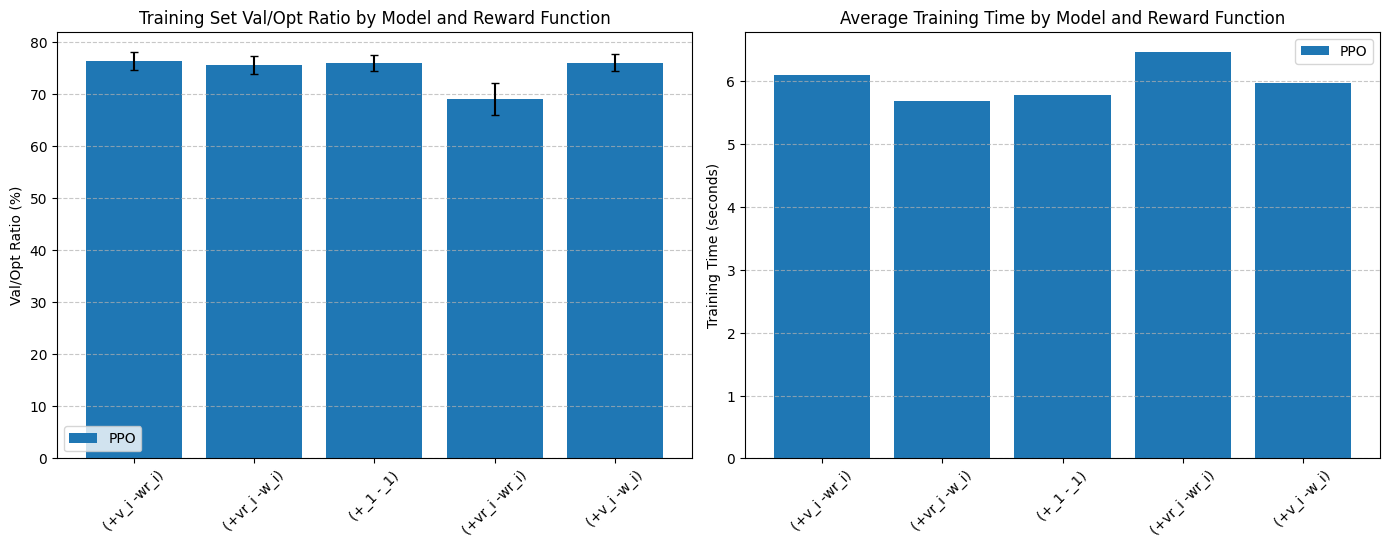

In [ ]:
visualize_results_with_error_bars(results)